<a href="https://colab.research.google.com/github/mehdi-or/203B/blob/master/Mnist_fashion_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import IPython as IP
IP.get_ipython().magic('reset -f')
import numpy as np
from keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras import optimizers
from keras.layers import Input, Dense, concatenate, Dropout, Lambda
from tensorflow.keras.utils import to_categorical
#import pydotplus
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas import DataFrame
import os
from scipy import stats
from keras import backend as K
from keras.regularizers import l2
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import GridSearchCV
#keras.utils.vis_utils.pydotplus = pydotplus
from keras.utils.vis_utils import plot_model
start = time.time()
#%reset -f

In [33]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


DNN architechture

In [43]:
encoding_dim = 2
drop = 0.02
activation_BT = 'linear'
num_epoch = 30
lr = 1e-4
discription = [str(encoding_dim), activation_BT, str(num_epoch), str(lr)]
def AE(encoding_dim):
      # this is our input placeholder for VT (creating a tensor)
      decoding_vox = Input(shape=(X_train.shape[1],), name="VT-input")

      encoded = Dense(512, activation='tanh', name="encoded_VT")(decoding_vox)
      encoded= Dropout(drop)(encoded)
      
      Bneck = Dense(encoding_dim, activation=activation_BT, name="Bneck")(encoded)
        
      decoded = Dense(512, activation='tanh', name="decoded-VT")(Bneck)
      decoded= Dropout(drop)(decoded)
      
      decoded = Dense(X_train.shape[1], activation='linear', name="decoded-output")(decoded)
      decoded= Dropout(drop)(decoded)
      

      encoder = Model(decoding_vox, Bneck)
      decoder = Model(decoding_vox, decoded) # model architecture
      plot_model(decoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
      
      
      bn_model = Model(inputs= decoder.input, outputs = decoder.get_layer('Bneck').output)
    
      # fitting the model and defining loss functiojn for each imput
      opt = optimizers.Adam(lr)
      decoder.compile(opt, loss='mean_squared_error', metrics=['mse', 'accuracy'])
      return decoder, encoder, Bneck, bn_model

import data from subjects

defining the logistic classifier

In [44]:
def classifier_AE (shape):
  BN_feat = Input(shape=shape, name="BN")
  out_class = Dense(classes.shape[0], activation='softmax', name ="output", kernel_regularizer=l2(0.007))(BN_feat)
  classifier = Model(BN_feat, out_class, name='classifier')
  opt = optimizers.Adam(lr = 5e-5)
  classifier.compile(opt, loss = 'categorical_crossentropy',  metrics =['accuracy'])
  return classifier


importing MNIST

In [45]:
which_data = ['mnist', 'fashion_mnist', 'cifar10']
#select_data = 'fashion_mnist'
select_data = 'mnist'
if select_data == which_data[0]:
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = np.reshape(X_train/255,(X_train.shape[0],X_train.shape[1]**2))
  X_test = np.reshape(X_test/255,(X_test.shape[0],X_test.shape[1]**2))
elif select_data == which_data[1]:
  (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
  X_train = np.reshape(X_train/255,(X_train.shape[0],X_train.shape[1]**2))
  X_test = np.reshape(X_test/255,(X_test.shape[0],X_test.shape[1]**2))
else:
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()

classes = np.unique(y_test)
class_number = len(classes)
labels2categ = to_categorical(y_test, num_classes = class_number)
y_categ_train = to_categorical(y_train, num_classes= class_number)
y_categ_test = to_categorical(y_test, num_classes=class_number)

fitting the AE model

taining in progress for BN = 5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


taining in progress for BN = 2


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


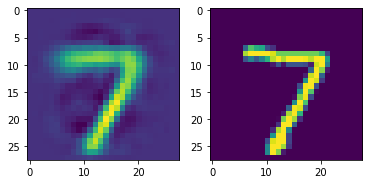

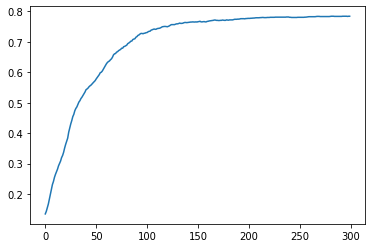

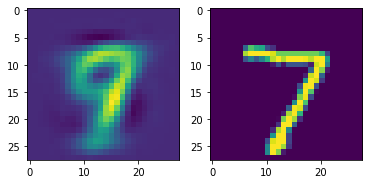

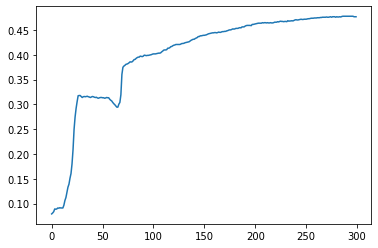

In [46]:
accuracy = []
#encoding_dims = [1500, 1000, 500, 250, 200, 150, 100, 60, 50, 30, 20, 15, 10, 5, 2]
encoding_dims = [5, 2]
start_t = time.time()
for i, encoding_dim in enumerate(encoding_dims):

  decoder_plain, encoder_plain, Bneck_plain, bn_model_plain= AE(encoding_dim)
  print('taining in progress for BN = '+ str(encoding_dim))
  decoder_plain.fit(X_train, X_train, epochs= num_epoch, shuffle=True, validation_data=(X_test,X_test), verbose=0)
  intermediate_layer_model = Model(inputs=decoder_plain.input, outputs=decoder_plain.get_layer('Bneck').output)
  BottleNeck_plain = intermediate_layer_model.predict(X_test)
  bt_features = bn_model_plain.predict(X_test)
  decoded_plain = decoder_plain.predict(X_test)
  s = int(np.sqrt(decoded_plain.shape[1]))
  decoded_plain0 = np.reshape(decoded_plain,(decoded_plain.shape[0],s,s))
  X_test0 = np.reshape(X_test,(X_test.shape[0],s,s))
  fig , (ax1, ax2) = plt.subplots(1,2)
  ax1.imshow(decoded_plain0[0,:,:])
  ax2.imshow(X_test0[0,:,:])

  corr = np.corrcoef(decoded_plain, X_test)
  ### logistic classifier ###
  scl = StandardScaler()
  BN_feat_scl = scl.fit_transform(BottleNeck_plain)
  #chossing the learning rate is very important
  shape = BottleNeck_plain.shape[1]
  classifier = classifier_AE(shape)
  history = classifier.fit(BN_feat_scl, labels2categ, epochs=300, shuffle=True, validation_split = 0.2, verbose=0)
  accuracy.append(history.history['val_accuracy'][-1])
  ''''
  np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/MNIST_fasion/BN_dim_' + str(encoding_dim)+ '.csv', BottleNeck_plain, delimiter=',')
  np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/MNIST_fasion/decoded_plain_' + str(encoding_dim)+ '.csv', decoded_plain, delimiter=',')
  decoder_plain.save('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/MNIST_fasion/decoder_dim_'+ str(encoding_dim))
  np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/MNIST_fasion/val_train_dim_' + str(encoding_dim)+ '.csv', history.history['val_accuracy'], delimiter=',')  
  np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/MNIST_fasion/correlation_' + str(encoding_dim)+ '.csv', corr, delimiter=',')
  #np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/MNIST_fasion/AE/map_test_indx' + str(encoding_dim)+ '.csv', map_test_index, delimiter=',')    
  '''
  plt.figure()
  plt.plot(np.asarray(history.history['val_accuracy']))
  #print(class_accuracy)
end_t=time.time()
duration = (end_t - start_t)/3600
#np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/MNIST_fasion/X_test.csv', X_test, delimiter=',')
#np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/MNIST_fasion/accuVsdim.csv', np.array([encoding_dims, accuracy]).T, delimiter=',')


In [10]:
duration

0.1784849038388994

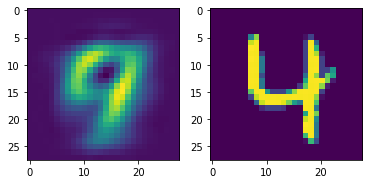

In [11]:
plt.subplot(1,2,1)
plt.imshow(decoded_plain0[49,:,:])
plt.subplot(1,2,2)
plt.imshow(X_test0[49,:,:])

Plotting

Text(0.5, 1.0, 'BN features')

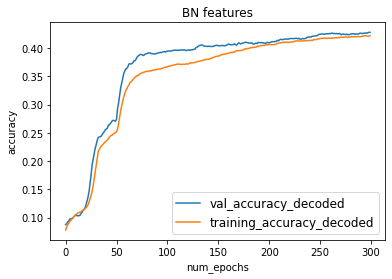

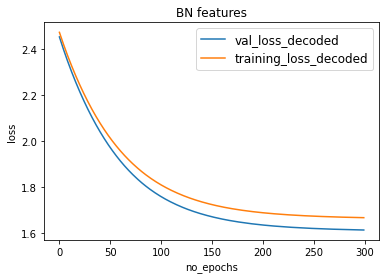

In [12]:
plt.figure(1)
plt.plot(np.asarray(history.history['val_accuracy']))
plt.plot(np.asarray(history.history['accuracy']))
plt.gca().legend(('val_accuracy_decoded','training_accuracy_decoded'), prop={'size': 12})
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.title('BN features')

plt.figure(2)
plt.plot(np.asarray(history.history['val_loss']))
plt.plot(np.asarray(history.history['loss']))
plt.gca().legend(('val_loss_decoded','training_loss_decoded'), prop={'size': 12})
plt.xlabel('no_epochs')
plt.ylabel('loss')
plt.title('BN features')

NameError: ignored

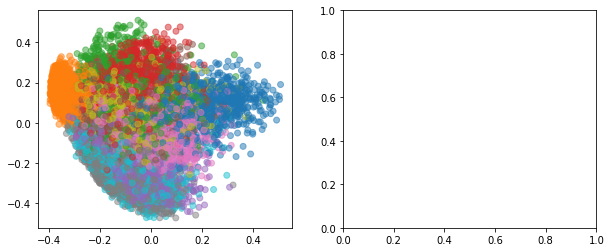

In [13]:
fig_plain , ax_plain = plt.subplots(1,2,figsize=(10,4))
font1 = {'family':'serif','color':'black','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
comp_plain1 = BottleNeck_plain[:,0]
comp_plain2 = BottleNeck_plain[:,1]
#comp3 = BottleNeck[:,2]
cmap = plt.cm.get_cmap('tab10')
fig1 = ax_plain[0].scatter(comp_plain1, comp_plain2, c= y_test, cmap=cmap, alpha=.5)
fig2 = ax_plain[1].scatter(Y_C2[:,0], Y_C2[:,1], c= y_test, cmap=cmap, alpha=.5)
#fig_plain.colorbar(fig)
ax_plain[0].set_xlabel('dim_1', fontdict = font1)
ax_plain[0].set_ylabel('dim_2',fontdict = font1)

plotting the model

In [ ]:
plot_model(decoder, show_shapes=True, show_layer_names=True)

another AE architecture (AE+classifier)

In [15]:
encoding_dim = 2
drop = 0.02
activation_BT = 'linear'
num_epoch = 30
lr = 1e-4
discription = [str(encoding_dim), activation_BT, str(num_epoch), str(lr)]
def AE_plus(encoding_dim):
      # this is our input placeholder for VT (creating a tensor)
      decoding_vox = Input(shape=(X_train.shape[1],), name="VT-input")

      encoded = Dense(512, activation='tanh', name="encoded_VT")(decoding_vox)
      encoded= Dropout(drop)(encoded)
      
      Bneck = Dense(encoding_dim, activation=activation_BT, name="Bneck")(encoded)
       
      decoded = Dense(512, activation='tanh', name="decoded-VT")(Bneck)
      decoded= Dropout(drop)(decoded)
      
      classifier1 = Dense(10, activation='softmax', name='classifier')(Bneck)
      decoded = Dense(X_train.shape[1], activation='linear', name="decoded-output")(decoded)
      decoded= Dropout(drop)(decoded)
            
      encoder = Model(decoding_vox, Bneck)
      decoder = Model(decoding_vox, [decoded, classifier1]) # model architecture
      plot_model(decoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
            
      bn_model = Model(inputs= decoder.input, outputs = decoder.get_layer('Bneck').output)
      #just_classifier = Model (inputs=Bneck, outputs=classifier1)
      #weights_classifier = just_classifier.get_weights() # returs a numpy list of weights
      # weights_classifier2 =decoder.layers['classifier'].weights
      # fitting the model and defining loss functiojn for each imput

      names = [weight.name for layer in decoder.layers for weight in layer.weights]
      weights = decoder.get_weights()

      opt = optimizers.Adam(lr)
      decoder.compile(opt, loss=['mean_squared_error', 'categorical_crossentropy'], loss_weights=[1, 0.01])
      return decoder, encoder, Bneck, bn_model, names, weights

fiting the AE+ model

taining in progress for BN = 5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


taining in progress for BN = 2


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0.18410067584779527


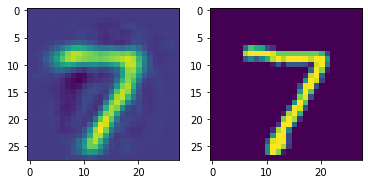

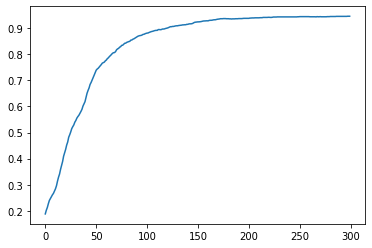

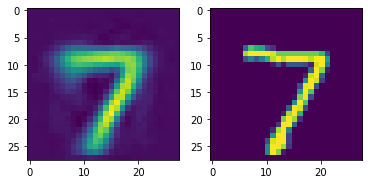

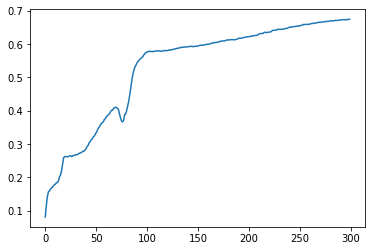

In [16]:
start_t = time.time()
accuracy_plus = []
#encoding_dims = [1500, 1000, 500, 250, 200, 150, 100, 60, 50, 30, 20, 15, 10, 5, 2]
encoding_dims = [5, 2]
for encoding_dim in encoding_dims:
  decoder, encoder, Bneck, bn_model, names, weights= AE_plus(encoding_dim)
  #for name, weight in zip(names, weights):
    #print(name, weight.shape)
  print('taining in progress for BN = '+ str(encoding_dim))
  decoder.fit(X_train, [X_train, y_categ_train], epochs= num_epoch, shuffle=True, validation_data=(X_test,[X_test, y_categ_test]), verbose=0)
  intermediate_layer_model = Model(inputs=decoder.input, outputs=decoder.get_layer('Bneck').output)
  BottleNeck_plus = intermediate_layer_model.predict(X_test)
  bt_features = bn_model.predict(X_test)
  [decoded_plus, classify] = decoder.predict(X_test)
  s=int(np.sqrt(decoded_plus.shape[1]))
  decoded_plus0=np.reshape(decoded_plus,(decoded_plus.shape[0],s,s))
  X_test0 = np.reshape(X_test,(X_test.shape[0],s,s))
  fig , (ax1, ax2)= plt.subplots(1,2)
  ax1.imshow(decoded_plus0[0,:,:])
  ax2.imshow(X_test0[0,:,:])

  #corr = np.corrcoef(decoded_plus, X_test)
  ### logistic classifier ###

  #scl = MinMaxScaler(feature_range=(0,1))
  scl = StandardScaler()
  BN_feat_scl = scl.fit_transform(BottleNeck_plus)
  #chossing the learning rate is very important
  shape = BottleNeck_plus.shape[1]
  classifier = classifier_AE(shape)
  history_plus = classifier.fit(BN_feat_scl, y_categ_test, epochs=300, shuffle=True, validation_split = 0.2, verbose=0)
  accuracy_plus.append(history_plus.history['val_accuracy'][-1])
  ''''
  np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/BN_dim_' + str(encoding_dim)+ '.csv', BottleNeck_plus, delimiter=',')
  np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/decoded_plus_' + str(encoding_dim)+ '.csv', decoded_plus, delimiter=',')
  decoder.save('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/decoder_dim_'+ str(encoding_dim))
  np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/val_train_dim_' + str(encoding_dim)+ '.csv', history.history['val_accuracy'], delimiter=',')  
  np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/correlation_' + str(encoding_dim)+ '.csv', corr, delimiter=',')
  #np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/map_test_indx' + str(encoding_dim)+ '.csv', map_test_index, delimiter=',')    
  '''
  plt.figure()
  plt.plot(np.asarray(history_plus.history['val_accuracy']))
  #print(class_accuracy)
#np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/X_test.csv', X_test, delimiter=',')
#np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/accuVsdim.csv', np.array([encoding_dims, accuracy_plus]).T, delimiter=',')
stop_t = time.time()
duration_plus = (stop_t- start_t)/3600
print(duration_plus)

In [17]:
print(duration_plus)

0.18410067584779527


plotting the model

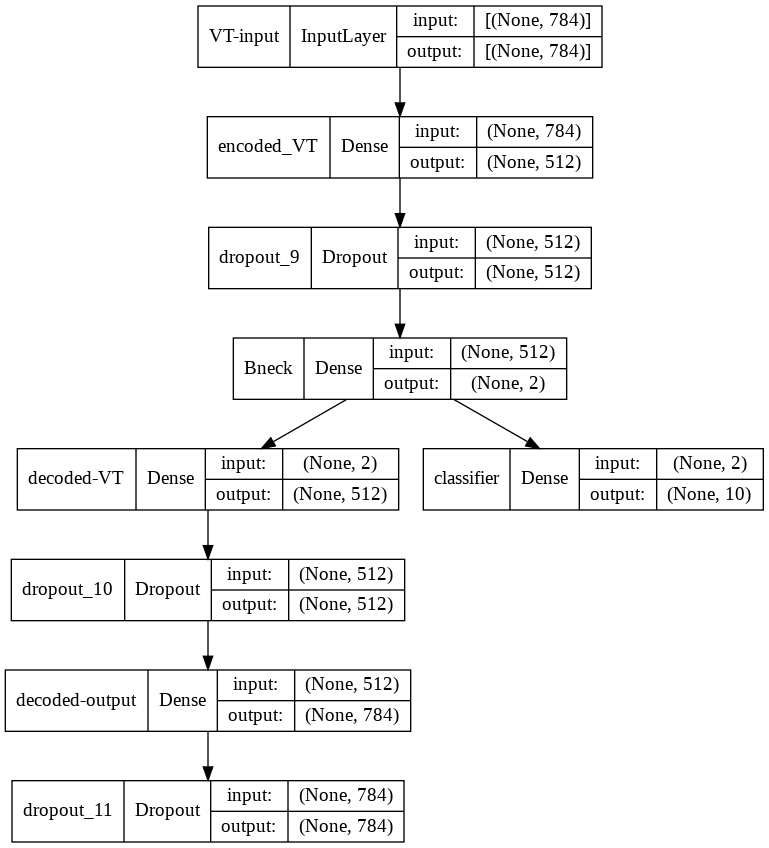

In [18]:
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(decoded_plain0_plain[6666,:,:])
plt.subplot(1,2,2)
plt.imshow(X_test0[6666,:,:])

In [ ]:
plt.imshow(decoded_pixels0[49,:,:])
plt.figure(2)
plt.imshow(X_test0[49,:,:])

logistic classifier

In [ ]:
classes = np.unique(y_test)
class_number = len(classes)
labels2categ = to_categorical(y_test, num_classes = class_number)
scl = MinMaxScaler(feature_range=(0,1))
BN_feat_scl = scl.fit_transform(BottleNeck_plus)

BN_feat = Input(shape=(BottleNeck_plus.shape[1],), name="BN")
out_class = Dense(classes.shape[0], activation='softmax', name ="output", kernel_regularizer=l2(0.007))(BN_feat)
classifier = Model(BN_feat, out_class, name='classifier')
#chossing the learning rate is very important
opt = optimizers.Adam(lr = 5e-5)
classifier.compile(opt, loss = 'categorical_crossentropy',  metrics =['accuracy'])

#labels2categ = to_categorical(labels2num[0, :], num_classes=len(class_number))
history=classifier.fit(BottleNeck_plus, labels2categ, epochs=300, shuffle=True, validation_split = 0.2, verbose=0)



Plotting


Text(0.5, 1.0, 'BN features')

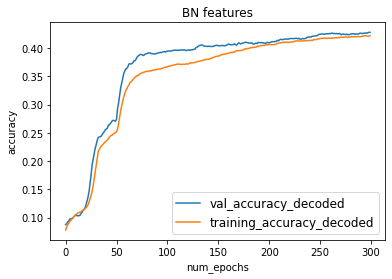

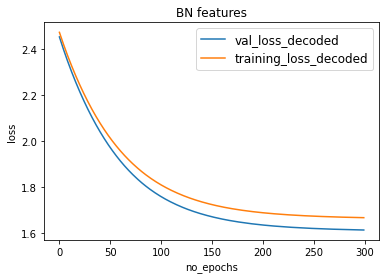

In [20]:
plt.figure(1)
plt.plot(np.asarray(history.history['val_accuracy']))
plt.plot(np.asarray(history.history['accuracy']))
plt.gca().legend(('val_accuracy_decoded','training_accuracy_decoded'), prop={'size': 12})
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.title('BN features')

plt.figure(2)
plt.plot(np.asarray(history.history['val_loss']))
plt.plot(np.asarray(history.history['loss']))
plt.gca().legend(('val_loss_decoded','training_loss_decoded'), prop={'size': 12})
plt.xlabel('no_epochs')
plt.ylabel('loss')
plt.title('BN features')

Text(0, 0.5, 'BN_dim_1')

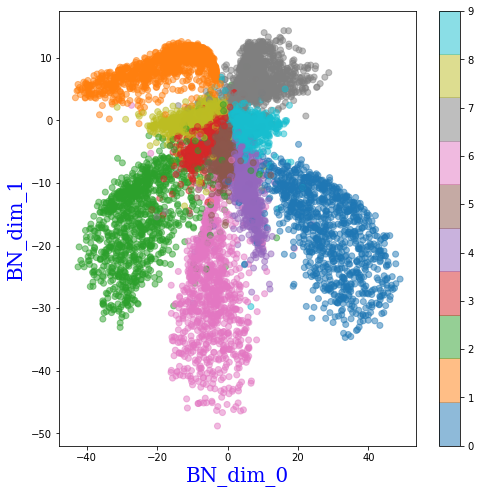

In [47]:
BottleNeck_plus = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST/BN_dim_2.csv', header=None).values
fig_plus , ax_plus = plt.subplots(figsize=(8,8))
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
comp1 = BottleNeck_plus[:,0]
comp2 = BottleNeck_plus[:,1]
#comp3 = BottleNeck_plus[:,2]
cmap = plt.cm.get_cmap('tab10')
fig = ax_plus.scatter(comp1, comp2, c= y_test, cmap=cmap, alpha=.5)
fig_plus.colorbar(fig)


ax_plus.set_xlabel('BN_dim_0', fontdict = font1)
ax_plus.set_ylabel('BN_dim_1',fontdict = font1)

[]

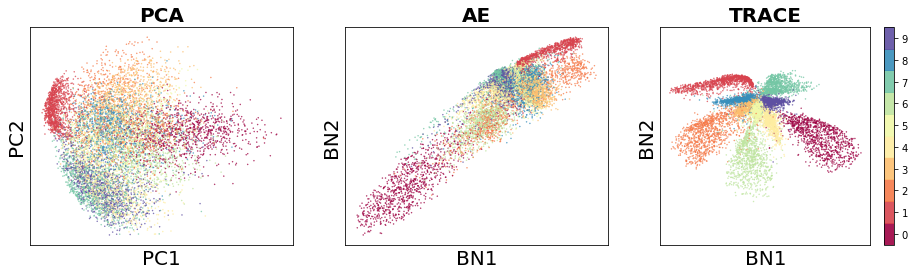

In [67]:
fig_plain , ax_plain = plt.subplots(1,3,figsize=(16,4))
font1 = {'family':'Ariel','color':'black','size':20, 'weight':'bold'}
font2 = {'family':'Ariel','color':'black','size':20}

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Y_C = pca.fit_transform(X_test)
comp1 = Y_C[:,0]
comp2 = Y_C[:,1]
comp_plain1 = BottleNeck_plain[:,0]
comp_plain2 = BottleNeck_plain[:,1]
comp_plus1 = BottleNeck_plus[:,0]
comp_plus2 = BottleNeck_plus[:,1]
#comp3 = BottleNeck[:,2]
#cmap = plt.cm.get_cmap('Set1')
fig1 = ax_plain[0].scatter(comp1, comp2, c= y_test, cmap='Spectral', alpha=.9, s=0.2)
fig2 = ax_plain[1].scatter(comp_plain1, comp_plain2, c= y_test, cmap='Spectral', alpha=.9, s=0.2)
fig3 = ax_plain[2].scatter(comp_plus1, comp_plus2, c= y_test, cmap='Spectral', alpha=.9, s=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(fig1,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
ax_plain[0].set_xlabel('PC1', fontdict = font2)
ax_plain[0].set_ylabel('PC2',fontdict = font2)
ax_plain[1].set_xlabel('BN1', fontdict = font2)
ax_plain[2].set_ylabel('BN2',fontdict = font2)
ax_plain[2].set_xlabel('BN1', fontdict = font2)
ax_plain[1].set_ylabel('BN2',fontdict = font2)
ax_plain[0].set_title('PCA',fontdict = font1)
ax_plain[1].set_title('AE', fontdict = font1)
ax_plain[2].set_title('TRACE', fontdict = font1)
ax_plain[0].set_yticks([])
ax_plain[1].set_yticks([])
ax_plain[2].set_yticks([])
ax_plain[0].set_xticks([])
ax_plain[1].set_xticks([])
ax_plain[2].set_xticks([])

In [ ]:
X_test0.shape

(10000, 28, 28)

Text(0.5, 1.0, 'Actual')

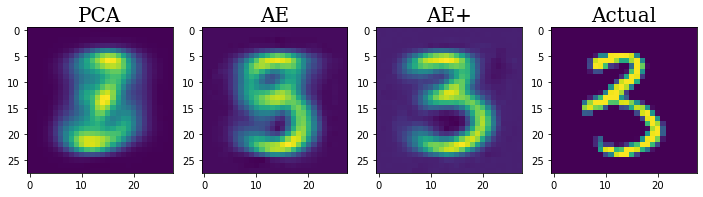

In [ ]:
figs , axs = plt.subplots(1,4,figsize=(12,4))
font1 = {'family':'serif','color':'black','size':20}
font2 = {'family':'serif','color':'black','size':15}
decoded_pca=pca.inverse_transform(Y_C)
decoded_pca0=np.reshape(decoded_pca,(decoded_pca.shape[0],s,s))
X_test0 = np.reshape(X_test, (decoded_pca.shape[0],s,s))
axs[0].imshow(decoded_pca0[5000,:])
axs[1].imshow(decoded_plain0[5000,:])
axs[2].imshow(decoded_plus0[5000,:])
axs[3].imshow(X_test0[5000,:])
axs[0].set_title('PCA',fontdict = font1)
axs[1].set_title('AE',fontdict = font1)
axs[2].set_title('AE+',fontdict = font1)
axs[3].set_title('Actual',fontdict = font1)